In [3]:
import data
import seaborn as sns
import numpy as np
import pandas as pd
import patsy
%matplotlib inline

/home/jacquelineburos/projects/immune-infiltrate-explorations/.env/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [4]:
import pystan
import stanity

In [ ]:
sns.set(context='talk')

## load files for all cell types

In [5]:
# list types of cells
subsets = data.prep_filename_metadata()
subsets['SubSet'].unique()
all_types = list(subsets['SubSet'].unique())
print(all_types)

['CD4_Th2', 'CD8_Effector', 'B_CD5', 'B_Memory', 'CD4_Th1', 'CD4_Naive', 'B_Naive', 'CD4_Effector_Memory', 'CD8_Central_Memory', 'CD4_Central_Memory', 'CD4_Treg', 'CD8_Naive', 'CD4_Th17']


In [6]:
df = data.load_by_cell_type(all_types, metadata=subsets)

In [7]:
df = data.prep_annotated_data(df)

In [8]:
assert all(pd.notnull(df['log1p_tpm_rescaled']))

## prep gene ids

For model-estimation, we first need to map each gene_name to a numeric ID. 


In [9]:
df['gene_cat'] = df['gene_name'].astype('category')
df['gene_id'] = df['gene_cat'].cat.codes+1

In [10]:
df['B_cell'] = df['cell_type'].apply(lambda x: 1 if x == 'B' else 0)
df['T_cell'] = df['cell_type'].apply(lambda x: 1 if x != 'B' else 0)

In [11]:
df.head()

,sample_id,filename,gene_name,est_counts,tpm,log1p_tpm,log1p_counts,CCR6,CCR7,CD127,...,CXCR3,SubSet,cell_type,log1p_tpm_rescaled_type,log1p_tpm_rescaled_subset,log1p_tpm_rescaled,gene_cat,gene_id,B_cell,T_cell
0,1,ERR431566,A1BG,56.743290,6.931783,2.070878,4.056007,None,None,None,...,,CD4_Th2,CD4,-5.599303,-3.517738,-5.478180,A1BG,1,0,1
1,1,ERR431566,A1CF,5.194920,0.111335,0.105562,1.823730,None,None,None,...,,CD4_Th2,CD4,-1.164584,-1.529020,-0.735391,A1CF,2,0,1
2,1,ERR431566,A2M,10.000009,3.877857,1.584706,2.397896,None,None,None,...,,CD4_Th2,CD4,1.338389,-0.920287,1.188265,A2M,3,0,1
3,1,ERR431566,A2ML1,9.387660,1.860813,1.051106,2.340619,None,None,None,...,,CD4_Th2,CD4,1.092135,1.947468,0.895292,A2ML1,4,0,1
4,1,ERR431566,A2MP1,31.000030,3.441394,1.490968,3.465737,None,None,None,...,,CD4_Th2,CD4,1.945796,4.135726,1.532385,A2MP1,5,0,1


## sample genes for first pass

In [25]:
sample_df = data.prep_sample_df(df, sample_n=100)

## fit model at level of cell-type

In [29]:

def prep_stan_data(sample_df):
    stan_data = {'N': len(sample_df.index),
             'G': len(sample_df.new_gene_id.unique()),
             'S': len(sample_df.new_sample_id.unique()),
             'C': 2,
             'gene': sample_df.new_gene_id.values,
             'sample': sample_df.new_sample_id.values,
             'x': patsy.dmatrix('0 + B_cell + T_cell', data=sample_df, return_type='dataframe'),
             'y': sample_df.est_counts.astype(int).values,
            }
    return stan_data


In [30]:
stan_data = prep_stan_data(sample_df)

In [136]:
## rewrite stan code to try to use matrix representation
## (ultimately, seems likely we will want to use sparse matrices)
stan_code3 = '''
data {
    // dimensions
    int<lower=1> N;  // N obs
    int<lower=1> G;  // N genes
    int<lower=1> S;  // N samples
    int<lower=0> C;  // N classes (e.g. B-cell, T-cell, B_Naive, CD5, CD45RO, etc)
                     // note: classes should be mutually exclusive. Each row here should sum to 1
   
    // data
    int<lower=1, upper=G> gene[N];    // gene id for each obs
    int<lower=1, upper=S> sample[N];  // sample id for each obs
    vector<lower=0, upper=1>[C] x[N]; // map each obs to each class (0:'- or ?', 1:'+')
    int<lower=0> y[N];                // count/tpm for each obs
}
transformed data {
    int sample_y[S, G]; // array (size SxG) of ints
    vector[C] sample_x[S]; // array (size S) of vectors[C]
    for (n in 1:N) {
        sample_y[sample[n], gene[n]] = y[n];
        sample_x[sample[n]] = x[n,];
    }
}
parameters {
    matrix<lower=0>[G, C] theta;   // loading factors for each gene, for each cell type
    vector[G] log_gene_base;    // constant intercept expression level for each gene, irrespective of cell type
}
model {
    for (i in 1:G)
        theta[i] ~ normal(0, 1);
    log_gene_base ~ normal(0, 1);
    for (s in 1:S) {
        vector[G] log_expected_rate;
        log_expected_rate = log_gene_base + log(theta*sample_x[s]);
        sample_y[s] ~ poisson_log(log_expected_rate);
    }
}
generated quantities {
    int y_rep[N];
    real log_lik[N];
    
    for (n in 1:N) {
        real log_expected_rate;
        log_expected_rate = log_gene_base[gene[n]] + log(theta[gene[n], ]*x[n]);
        y_rep[n] = poisson_log_rng(log_expected_rate);
        log_lik[n] = poisson_log_lpmf(y[n] | log_expected_rate);
    }
}
'''

In [137]:
fit3 = data.cached_stan_fit(model_code=stan_code3, data=stan_data, iter=500, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6255c0000960d51a0a5cc85b061ed296 NOW.


NOT reusing model.
Ran in 395.466 sec.


/home/jacquelineburos/projects/immune-infiltrate-explorations/.env/lib/python3.5/site-packages/pyfscache/fscache.py:407: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


In [138]:
data.print_stan_summary(fit3, pars='theta')

                 mean   se_mean        sd      2.5%       50%     97.5%      Rhat
theta[0,0]   0.502971  0.013354  0.422298  0.043011  0.379905  1.557868  0.999437
theta[1,0]   0.631021  0.013141  0.415547  0.094824  0.528133  1.627405  0.998328
theta[2,0]   0.617622  0.013696  0.433104  0.085323  0.509623  1.732599  0.997395
theta[3,0]   0.171375  0.006214  0.196510  0.003794  0.107439  0.731891  1.000668
theta[4,0]   1.954643  0.017525  0.554201  1.001767  1.928824  3.146324  1.000147
theta[5,0]   0.461921  0.012864  0.406794  0.030669  0.336535  1.532833  0.999894
theta[6,0]   1.186868  0.016054  0.507684  0.362376  1.134158  2.300804  0.999825
theta[7,0]   1.260852  0.017165  0.542820  0.408238  1.215267  2.473369  0.998997
theta[8,0]   0.974506  0.014297  0.452121  0.274342  0.911975  1.966114  0.999044
theta[9,0]   1.149574  0.017516  0.553902  0.329295  1.060884  2.358110  0.998644
theta[10,0]  2.173641  0.016638  0.526131  1.194750  2.147897  3.242646  0.997454
theta[11,0]  1.7

In [139]:
theta_ldf = data.prep_theta_summary(fit3, sample_df=sample_df, expose_group='T_cell')

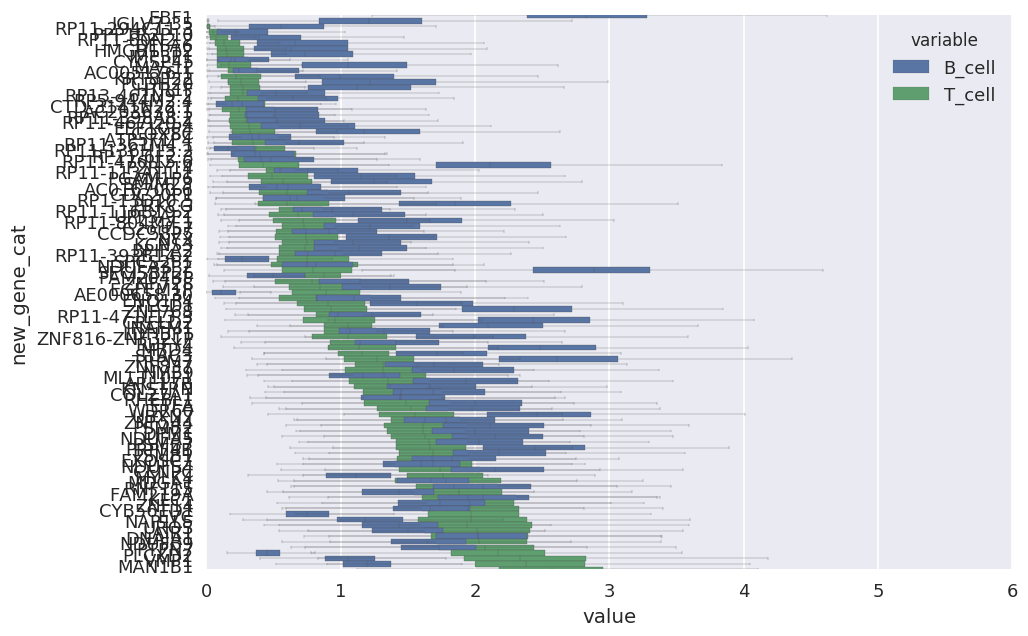

In [140]:
g = sns.boxplot(data=theta_ldf.sort_values('T_cell_mean'),
            y='new_gene_cat',
            x='value',
            hue='variable', 
            fliersize=0, width=2, linewidth=0.2)

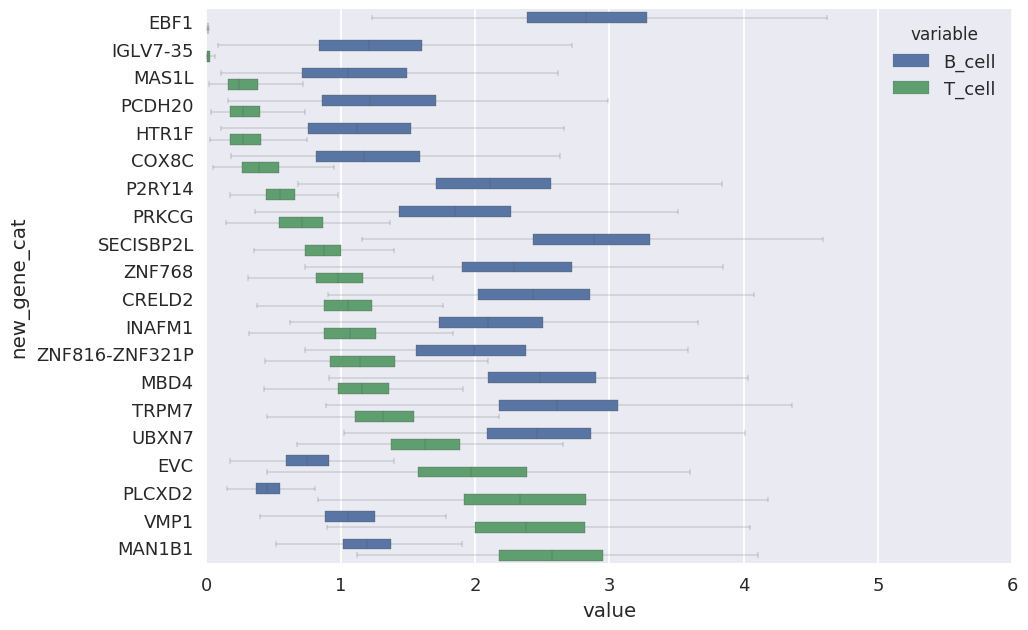

In [141]:
g = sns.boxplot(data=theta_ldf.query('abs(mean_diff)>0.4').sort_values(['T_cell_mean']),
            y='new_gene_cat',
            x='value',
            hue='variable', 
            fliersize=0, linewidth=0.2)


In [150]:
yrep_df = data.prep_yrep_summary(fit3, sample_df=sample_df)

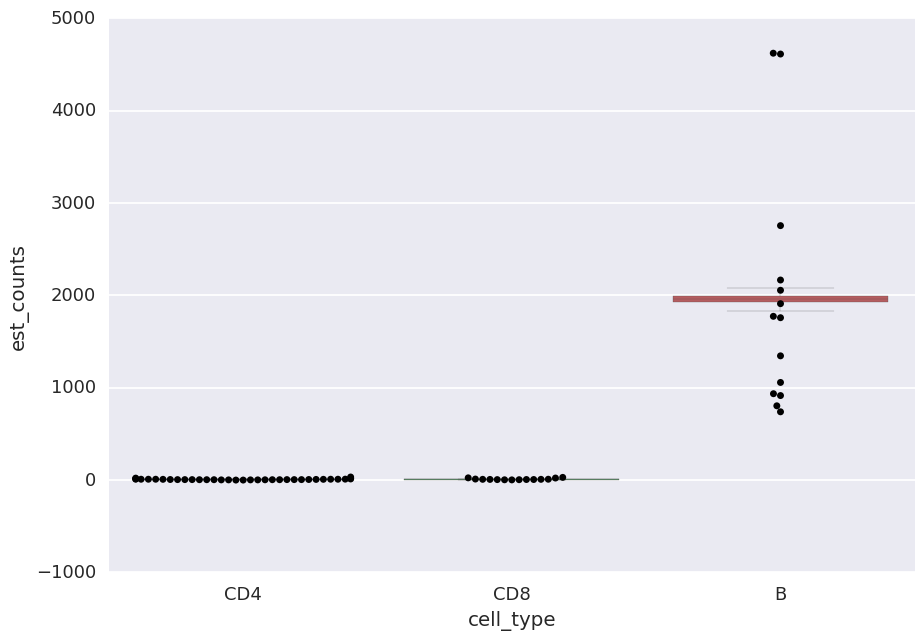

In [179]:
from matplotlib import pyplot as plt
sns.boxplot(data=yrep_df.query('gene_cat == "EBF1"'),
            x='cell_type',
            y='pp_est_counts',
            fliersize=0, linewidth=0.2)
sns.swarmplot(data=sample_df.loc[sample_df['gene_cat'] == "EBF1", :],
           x='cell_type',
           y='est_counts', color='black')

This is not great, since there is a lot more heterogeneity in these estimates than is enabled by the model.

We may want to try a different distribution than the poisson, or we may want to add a noise component to each transcript. 

### Same model with different effect distribution

Let's try a variation of the model above, using a different distribution for the counts.

In [180]:
stan_code4 = '''
data {
    // dimensions
    int<lower=1> N;  // N obs
    int<lower=1> G;  // N genes
    int<lower=1> S;  // N samples
    int<lower=0> C;  // N classes (e.g. B-cell, T-cell, B_Naive, CD5, CD45RO, etc)
                     // note: classes should be mutually exclusive. Each row here should sum to 1
   
    // data
    int<lower=1, upper=G> gene[N];    // gene id for each obs
    int<lower=1, upper=S> sample[N];  // sample id for each obs
    vector<lower=0, upper=1>[C] x[N]; // map each obs to each class (0:'- or ?', 1:'+')
    int<lower=0> y[N];                // count/tpm for each obs
}
transformed data {
    int sample_y[S, G]; // array (size SxG) of ints
    vector[C] sample_x[S]; // array (size S) of vectors[C]
    for (n in 1:N) {
        sample_y[sample[n], gene[n]] = y[n];
        sample_x[sample[n]] = x[n,];
    }
}
parameters {
    matrix<lower=0>[G, C] theta; // loading factors for each gene, for each cell type
    vector[G] log_gene_base;     // constant intercept expression level for each gene, irrespective of cell type
    vector<lower=0>[G] gene_phi;          // overdispersion parameter per transcript (for now)
}
model {
    for (i in 1:G)
        theta[i] ~ normal(0, 1);
    log_gene_base ~ normal(0, 1);
    gene_phi ~ normal(0, 1);
    for (s in 1:S) {
        vector[G] log_expected_rate;
        log_expected_rate = log_gene_base + log(theta*sample_x[s]);
        sample_y[s] ~ neg_binomial_2_log(log_expected_rate, gene_phi);
    }
}
generated quantities {
    int y_rep[N];
    real log_lik[N];
    
    for (n in 1:N) {
        real log_expected_rate;
        log_expected_rate = log_gene_base[gene[n]] + log(theta[gene[n], ]*x[n]);
        y_rep[n] = neg_binomial_2_log_rng(log_expected_rate, gene_phi[gene[n]]);
        log_lik[n] = neg_binomial_2_log_lpmf(y[n] | log_expected_rate, gene_phi[gene[n]]);
    }
}
'''

In [181]:
fit4 = data.cached_stan_fit(model_code=stan_code4, data=stan_data, iter=500, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_63b713b19b1a0d004cd7e3ebcdff29fa NOW.


NOT reusing model.
Ran in 201.991 sec.


/home/jacquelineburos/projects/immune-infiltrate-explorations/.env/lib/python3.5/site-packages/pyfscache/fscache.py:407: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


In [182]:
data.print_stan_summary(fit4, pars='theta')

                 mean   se_mean        sd      2.5%       50%     97.5%      Rhat
theta[0,0]   0.601917  0.014955  0.472911  0.038590  0.479075  1.727980  0.997768
theta[1,0]   0.654692  0.014165  0.447940  0.092621  0.568841  1.806532  0.998728
theta[2,0]   0.678231  0.014888  0.470800  0.086923  0.577467  1.773138  0.998099
theta[3,0]   0.204964  0.008147  0.257636  0.002447  0.117860  0.956995  0.997111
theta[4,0]   1.916367  0.017204  0.544039  0.943674  1.879189  3.111201  1.000253
theta[5,0]   0.538687  0.013967  0.441669  0.039402  0.428979  1.667163  0.997020
theta[6,0]   1.136822  0.016361  0.517368  0.345704  1.080822  2.255473  0.999151
theta[7,0]   1.218849  0.017146  0.542213  0.358844  1.140650  2.459806  0.999332
theta[8,0]   0.975253  0.015640  0.494586  0.202476  0.905921  2.104419  1.000550
theta[9,0]   1.111071  0.016822  0.531957  0.306490  1.034960  2.329017  1.002375
theta[10,0]  2.080247  0.018358  0.580540  1.083610  2.009295  3.322296  0.997654
theta[11,0]  1.6

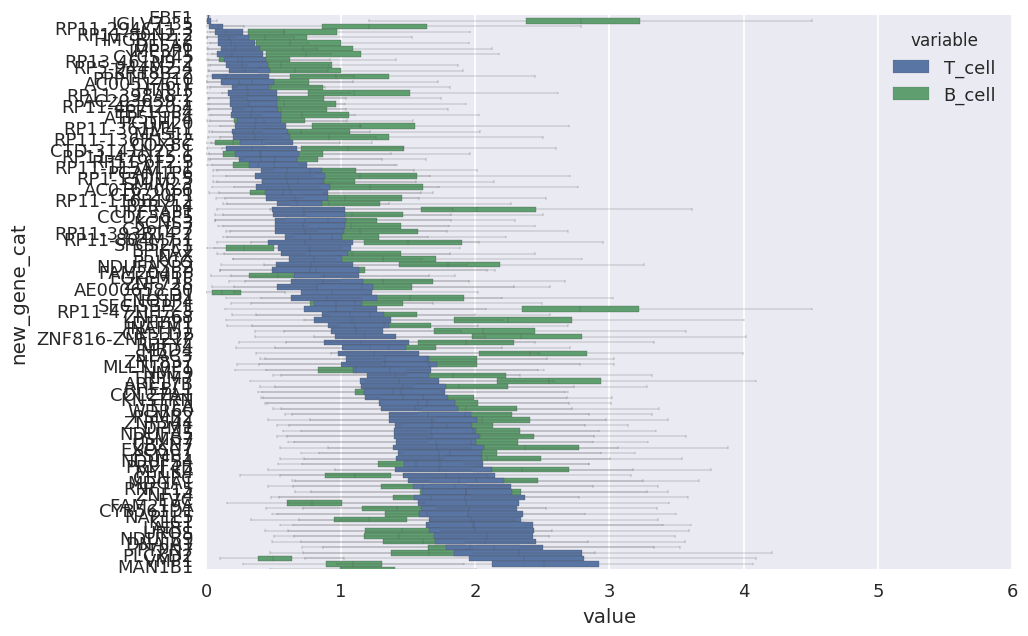

In [189]:
theta4_ldf = data.prep_theta_summary(fit4, sample_df=sample_df, expose_group='T_cell')
g = sns.boxplot(data=theta4_ldf.sort_values('T_cell_mean'),
            y='new_gene_cat',
            x='value',
            hue='variable', 
            fliersize=0, width=2, linewidth=0.2)

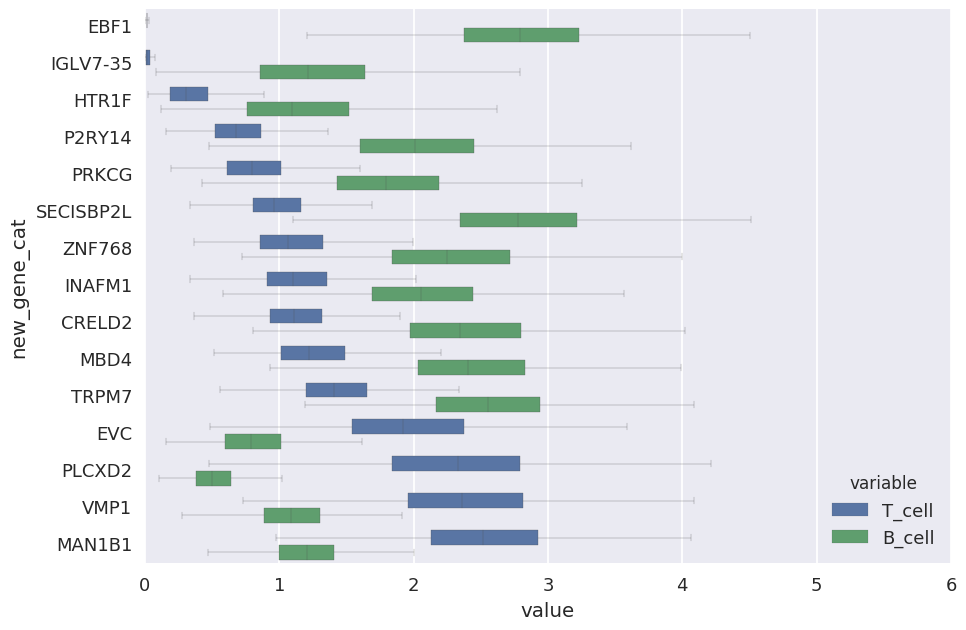

In [190]:
g = sns.boxplot(data=theta4_ldf.query('abs(mean_diff)>0.4').sort_values(['T_cell_mean']),
            y='new_gene_cat',
            x='value',
            hue='variable', 
            fliersize=0, linewidth=0.2)


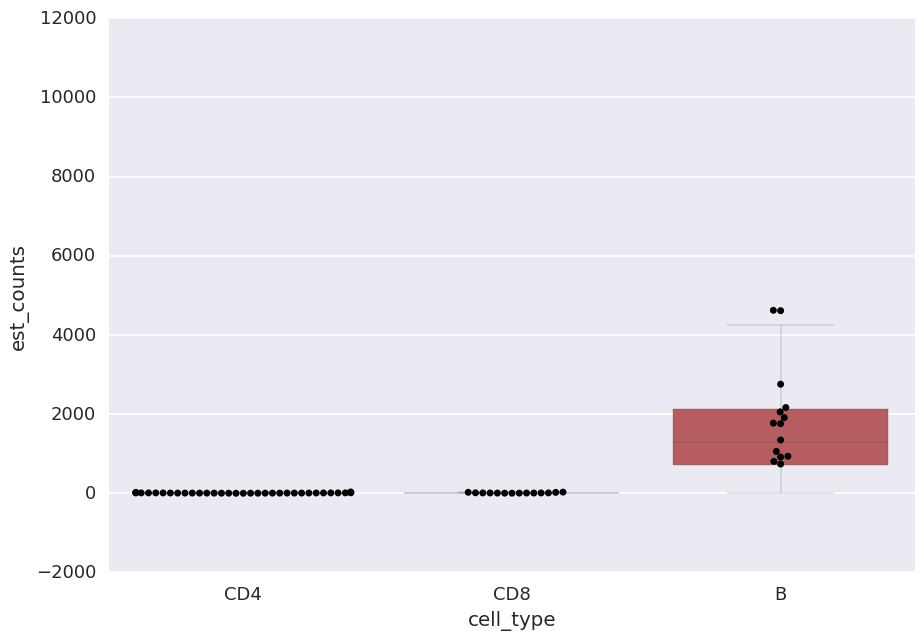

In [184]:
yrep4_df = data.prep_yrep_summary(fit4, sample_df=sample_df)

from matplotlib import pyplot as plt
sns.boxplot(data=yrep4_df.query('gene_cat == "EBF1"'),
            x='cell_type',
            y='pp_est_counts',
            fliersize=0, linewidth=0.2)
sns.swarmplot(data=sample_df.loc[sample_df['gene_cat'] == "EBF1", :],
           x='cell_type',
           y='est_counts', color='black')

Compare models using LOO

In [187]:
loo3 = stanity.psisloo(fit3.extract('log_lik')['log_lik'])
loo4 = stanity.psisloo(fit4.extract('log_lik')['log_lik'])

/home/jacquelineburos/projects/immune-infiltrate-explorations/.env/lib/python3.5/site-packages/stanity/psis.py:228: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif sort == 'in-place':
/home/jacquelineburos/projects/immune-infiltrate-explorations/.env/lib/python3.5/site-packages/stanity/psis.py:246: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  bs /= 3 * x[sort[np.floor(n/4 + 0.5) - 1]]


In [188]:
stanity.loo_compare(loo3, loo4)

{'diff': 207185.30636663269, 'se_diff': 14576.524307793481}

This suggests that model4 is a much (much!) better fit than model3.